In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Intro

In this notebook we create snake game (let's call it Silly Snake) in Python, using the pygame library. After we do this game, we do some minor modification on it in order to be able to train the AI to play it.

We will use Reinforcement Learning and a simple neural network to do the training. For the neural network we will use PyTorch.

The game we will use it's a snake game written in Python, using the module pygame. In this notebook we will not be able to see it running, but it will be trainned and we will be able to observe it progress!

I will add some images of the game and trainning runnin on my local machine, and of course I encorage you to run this code somewhere where you can see the game window.

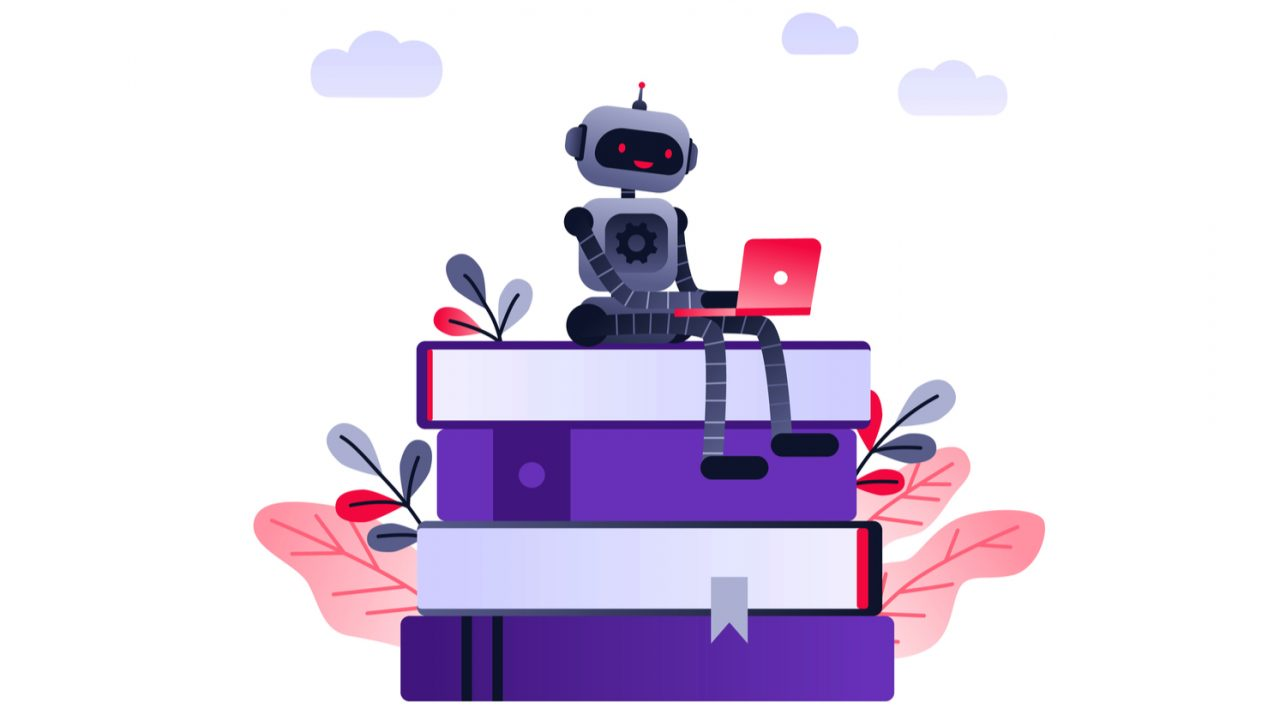

This notebook is heavily inspiered by [this](https://www.youtube.com/watch?v=--nsd2ZeYvs) and [this](https://www.youtube.com/watch?v=L8ypSXwyBds).



# Silly Snake Game and it's rules

Silly Snake is a plain snake game, the goal is to eat the "food" represented by the red dot and to avoid to colide on any obstacle. The obstacles can be the border or the snake itself. If the snake is moving right and we push left the game will consider this a collision and will result in a game over.

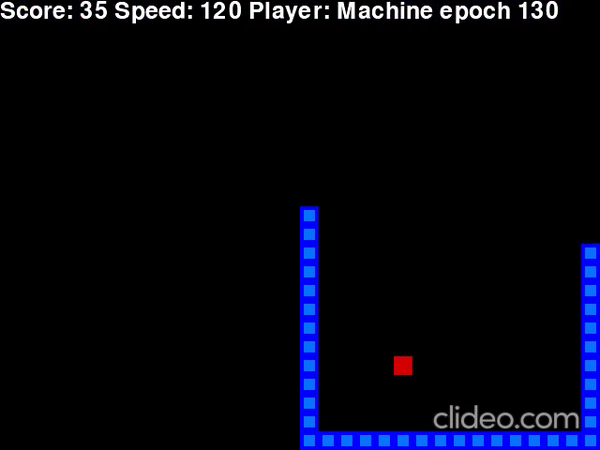


# Notebook environment setup

We must add the pygame module in order for this to work.

In [2]:
!pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 57.8 MB/s eta 0:00:00


# The plain Silly Snake game

This version of the game is the original, it is meant to be played by a human. It includes a main method.

In [3]:
# https://youtu.be/--nsd2ZeYvs?t=1256

import pygame
import random
from enum import Enum
from collections import namedtuple

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple("Point", "x, y")

# we substitute pygame.init() for the explicit init of inititng the display and fonts
# this will prevent sound init, which may cause issues on notebooks
pygame.display.init()
pygame.font.init()

font = pygame.font.Font(pygame.font.get_default_font(), 25)

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 10

class SnakeGame:

    def __init__(self, width=640, height=480, playerName="Player"):
        self.w = width
        self.h = height
        self.playerName = playerName

        # init display

        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption("Silly Snake")
        self.clock = pygame.time.Clock()

        # init game
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None

        self.placeFood()

    def placeFood(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self.placeFood()

    def playStep(self):
        # 1. collect user input

        for event in pygame.event.get():
            if event == pygame.QUIT:
                pygame.quit()
                quit()

            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_LEFT:
                    self.direction = Direction.LEFT
                elif event.key == pygame.K_RIGHT:
                    self.direction = Direction.RIGHT
                elif event.key == pygame.K_UP:
                    self.direction = Direction.UP
                elif event.key == pygame.K_DOWN:
                    self.direction = Direction.DOWN

        # 2. move the snake, asta creste si marimea sarpelui
        self.moveSnake(self.direction)
        # 3. check if game over

        if self.isCollision():
            gameOver = True

            return gameOver, self.score

        # 4. move snake or place food

        if self.head == self.food:
            self.score += 1
            self.placeFood()
        else:
            self.snake.pop()


        # 5. update ui and clock
        self.updateUi()
        self.clock.tick(SPEED)
        # 6. return game over and score
        gameOver = False

        return gameOver, self.score

    def isCollision(self):

        #check if it hits border

        if self.head.x > self.w - BLOCK_SIZE or self.head.x < 0:
            return True

        if self.head.y > self.h - BLOCK_SIZE or self.head.y < 0:
            return True

        # check if it hits itself

        if self.head in self.snake[1:]:
            return True

        return False


    def moveSnake(self, direction: Direction):

        x = self.head.x
        y = self.head.y

        if direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

        # this grows the size of our snake
        self.snake.insert(0, self.head)

    def updateUi(self):
        self.display.fill(BLACK)

        for p in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(p.x, p.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        scoreText = font.render("Score: " + str(self.score) + " Speed: " + str(SPEED) + " Player: " + self.playerName, True, WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()

def playGame(playerName = "Stefan"):

    game = SnakeGame(playerName=playerName)

    while True:
        gameOver, score = game.playStep()

        # break if game over

        if gameOver == True:
            break

    print("Game Over, final score: ", score)

    pygame.quit()

# include a main function, to be able to run the script, for notebooks we can comment this out
if __name__ == "__main__":
    playGame()

pygame 2.4.0 (SDL 2.26.4, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Game Over, final score:  0


# (Very) Quick intro to Reinforcement Learning

Reinforcement learning (RL) is an area of machine learning concerned with how intelligent agents ought to take actions in an environment in order to maximize the notion of cumulative reward. Reinforcement learning is one of three basic machine learning paradigms, alongside supervised learning and unsupervised learning.

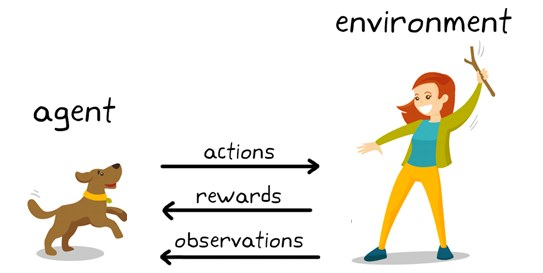

The type of RL that we will apply is Deep Q Learning (DQL). For this we will need an **enviorment**, an **agent**, a **model** and a **trainner**. All these components are described bellow.


# Defining the Enviorment

The **Enviorment** is the "place" where the agent will learn and will perform actions. 
In our case the **Enviorment** is version the Silly Snake game addapted to be playable by the AI.

In [4]:
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np

class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple("Point", "x, y")

# we substitute pygame.init() for the explicit init of inititng the display and fonts
# this will prevent sound init, which may cause issues on notebooks
pygame.display.init()
pygame.font.init()

font = pygame.font.Font(pygame.font.get_default_font(), 25)

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)

BLOCK_SIZE = 20
SPEED = 120

class SillySnakeGameAi:

    def __init__(self, width=640, height=480, playerName="Player"):
        self.w = width
        self.h = height
        self.playerName = playerName

        # init display

        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption("Silly Snake")
        self.clock = pygame.time.Clock()

        # init game
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT
        self.head = Point(self.w / 2, self.h / 2)
        self.snake = [self.head,
                      Point(self.head.x - BLOCK_SIZE, self.head.y),
                      Point(self.head.x - (2 * BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None

        self.placeFood()

        self.frameIteration = 0


    def placeFood(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self.placeFood()

    def playStep(self, action):
        # increment frame iteration

        self.frameIteration += 1

        for event in pygame.event.get():
            if event == pygame.QUIT:
                pygame.quit()
                quit()

        # 2. move the snake, asta creste si marimea sarpelui
        self.moveSnake(action)

        # reward stuff
        reward = 0

        # 3. check if game over

        if self.isCollision() or self.frameIteration > 100 * len(self.snake):
            gameOver = True

            reward -= 10

            return reward, gameOver, self.score

        # 4. move snake or place food

        if self.head == self.food:
            self.score += 1
            reward = 10
            self.placeFood()
        else:
            self.snake.pop()

        # 5. update ui and clock
        self.updateUi()
        self.clock.tick(SPEED)
        # 6. return game over and score
        gameOver = False

        return reward, gameOver, self.score

    def isCollision(self, p: Point = None):

        if p == None:
            p = self.head

        #check if it hits border
        if p.x > self.w - BLOCK_SIZE or p.x < 0:
            return True

        if p.y > self.h - BLOCK_SIZE or p.y < 0:
            return True

        # check if it hits itself

        if p in self.snake[1:]:
            return True

        return False

    def moveSnake(self, action):

        # action -> [straigth, right, left]
        clockWiseDirections = [Direction.RIGHT, Direction.DOWN, Direction.LEFT, Direction.UP]
        currentDirectionIndex = clockWiseDirections.index(self.direction)

        newDirection = self.direction

        if np.array_equal(action, [0, 1, 0]):
            newDirection = clockWiseDirections[(currentDirectionIndex + 1) % 4]
        elif np.array_equal(action, [0, 1, 0]):
            newDirection = clockWiseDirections[(currentDirectionIndex - 1) % 4]

        self.direction = newDirection

        x = self.head.x
        y = self.head.y

        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

        # this grows the size of our snake
        self.snake.insert(0, self.head)


    def updateUi(self):
        self.display.fill(BLACK)

        for p in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(p.x, p.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(p.x + 4, p.y + 4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        scoreText = font.render("Score: " + str(self.score) + " Speed: " + str(SPEED) + " Player: " + self.playerName, True, WHITE)

        self.display.blit(scoreText, [0, 0])

        pygame.display.flip()


    def setPlayerName(self, name):
        self.playerName = name

# Definine the Model

This is a simple neural network used for the training, it should have 11 input neurons (the size of our state array) and 3 output neuros, the number of our potential moves (straigth, left right).

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class LinearQNet(nn.Module):

    def __init__(self, inputSize, hiddenSize, outputSize):
        super().__init__()

        self.linear1 = nn.Linear(inputSize, hiddenSize)
        self.linear2 = nn.Linear(hiddenSize, outputSize)

    def forward(self, X):
        out = self.linear1(X)
        out = F.relu(out)
        out = self.linear2(out)

        return out

# The Trainner
This will be used to actually train our model based on the states, actions and the rewards provided by the agent.

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class QTrainner:

    def __init__(self, model, lr, gamma):
        self.model = model
        self.lr = lr
        self.gamma = gamma

        self.optimizer = optim.Adam(model.parameters(), self.lr)
        self.lossFunction = nn.MSELoss()

    def trainStep(self, state, action, reward, newState, done):

        stateTensor = torch.tensor(state, dtype=torch.float)
        actionTensor = torch.tensor(action, dtype=torch.long)
        rewardTensor = torch.tensor(reward, dtype=torch.float)
        newStateTensor = torch.tensor(newState, dtype=torch.float)

        if len(stateTensor.shape) == 1:
            stateTensor = torch.unsqueeze(stateTensor, 0)
            newStateTensor = torch.unsqueeze(newStateTensor, 0)
            actionTensor = torch.unsqueeze(actionTensor, 0)
            rewardTensor = torch.unsqueeze(rewardTensor, 0)
            done = (done, )

        # 1. predicted q values with current state
        prediction = self.model(stateTensor)

        # Q_new = 2. reward + gamma * max(next predicted q value) -> only do this if not done
        target = prediction.clone()

        for i in range(len(done)):
            Qnew = rewardTensor[i]

            if not done[i]:
                Qnew = rewardTensor[i] + self.gamma * torch.max(self.model(newStateTensor[i]))

            target[i][torch.argmax(actionTensor).item()] = Qnew


        self.optimizer.zero_grad()
        loss = self.lossFunction(target, prediction)
        loss.backward()

        self.optimizer.step()

# Defining the Agent
The **agent** is the component that does the learning and performs the actions.

In [7]:
import torch
import random
import numpy as np
from collections import deque

MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

class Agent:
    def __init__(self):
        self.numberOfGames = 0
        # controls randomness
        self.epsilon = 0
        # discount rate
        self.gamma = 0
        # the last actions, if we reach the limit we will remove the oldest
        self.memory = deque(maxlen=MAX_MEMORY)

        # the modelneeds to have 11 inputs, as our world status grid has 11 elements and the output is 3, as we have 3 directions
        self.model = LinearQNet(11, 256, 3)
        self.trainner = QTrainner(self.model, lr=LR, gamma=self.gamma)

    # this gives us the state of the world
    def getState(self, game):
        head = game.head

        point_left = Point(head.x - BLOCK_SIZE, head.y)
        point_right = Point(head.x + BLOCK_SIZE, head.y)
        point_up = Point(head.x, head.y - BLOCK_SIZE)
        point_down = Point(head.x, head.y + BLOCK_SIZE)

        direction_left = game.direction == Direction.LEFT
        direction_right = game.direction == Direction.RIGHT
        direction_up = game.direction == Direction.UP
        direction_down = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (direction_right and game.isCollision(point_right)) or
            (direction_left and game.isCollision(point_left)) or
            (direction_up and game.isCollision(point_up)) or
            (direction_down and game.isCollision(point_down)),

            # Danger right
            (direction_up and game.isCollision(point_right)) or
            (direction_down and game.isCollision(point_left)) or
            (direction_left and game.isCollision(point_up)) or
            (direction_right and game.isCollision(point_down)),

            # Danger left
            (direction_down and game.isCollision(point_right)) or
            (direction_up and game.isCollision(point_left)) or
            (direction_right and game.isCollision(point_up)) or
            (direction_left and game.isCollision(point_down)),

            # Move direction
            direction_left,
            direction_right,
            direction_up,
            direction_down,

            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
        ]

        return np.array(state, dtype=int)

    def remember(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))

    def trainLongMemory(self):
        if len(self.memory) < BATCH_SIZE:
            sample = self.memory
        else:
            sample = random.sample(self.memory, BATCH_SIZE)

        states, actions, rewards, nextStates, dones = zip(*sample)
        self.trainner.trainStep(states, actions, rewards, nextStates, dones)

    def trainShortMemory(self, state, action, reward, nextState, done):
        self.trainner.trainStep(state, action, reward, nextState, done)

    def getAction(self, state):
        # in the beginning will do some random moves, tradeoff between exploration and exploataition
        self.epsilon = 80 - self.numberOfGames
        finalMove = [0, 0, 0]

        if random.randint(0, 200) < self.epsilon:
            move = random.randint(0, 2)
            finalMove[move] = 1
        else:
            stateTensor = torch.tensor(state, dtype=torch.float)
            prediction = self.model(stateTensor)
            move = torch.argmax(prediction).item()
            finalMove[move] = 1

        return finalMove

# Training and letting AI play the game

Now to putting it all togheter, let let the agent train by playing the game. As we are in a notebook we will not see the game window, just the logs and progress graphs, but I will add some GIF in order to see the reuls. 

In [8]:
%%time

scoresHistory = []
meanScores = []

def train():
    
    totalScore = 0
    bestScore = 0

    agent = Agent()
    game = SillySnakeGameAi()

    # we train the model for 200 games
    while agent.numberOfGames < 200:

        game.setPlayerName("Machine epoch " + str(agent.numberOfGames))

        # get old state
        oldState = agent.getState(game)

        # move
        finalMove = agent.getAction(oldState)

        # perform move and get new state
        reward, done, score = game.playStep(finalMove)

        newState = agent.getState(game)

        # train short memory
        agent.trainShortMemory(oldState, finalMove, reward, newState, done)

        # remember
        agent.remember(oldState, finalMove, reward, newState, done)

        if done:
            # train long memory
            game.reset()
            agent.numberOfGames += 1
            agent.trainLongMemory()

            if score > bestScore:
                bestScore = score

            totalScore += score
            meanScore = (totalScore / agent.numberOfGames)

            scoresHistory.append(score)
            meanScores.append(meanScore)

            if score == bestScore or agent.numberOfGames % 10 == 0:
                print("Game number: ", agent.numberOfGames, "Score: ", score, "Best Score: ", bestScore, "Mean scores: ", meanScore)


# run the trainning method                
train()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)


Game number:  1 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  2 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  3 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  4 Score:  0 Best Score:  0 Mean scores:  0.0
Game number:  5 Score:  1 Best Score:  1 Mean scores:  0.2
Game number:  9 Score:  1 Best Score:  1 Mean scores:  0.2222222222222222
Game number:  10 Score:  0 Best Score:  1 Mean scores:  0.2
Game number:  12 Score:  1 Best Score:  1 Mean scores:  0.25
Game number:  14 Score:  1 Best Score:  1 Mean scores:  0.2857142857142857
Game number:  15 Score:  1 Best Score:  1 Mean scores:  0.3333333333333333
Game number:  17 Score:  1 Best Score:  1 Mean scores:  0.35294117647058826
Game number:  18 Score:  1 Best Score:  1 Mean scores:  0.3888888888888889
Game number:  20 Score:  0 Best Score:  1 Mean scores:  0.35
Game number:  21 Score:  1 Best Score:  1 Mean scores:  0.38095238095238093
Game number:  22 Score:  1 Best Score:  1 Mean scores:  0.40909090909090

This is how it looks when the AI plays the game,it has a pretty good run. The speed is set up high, but this does not bother the AI :)

# Plotting the trainning progress

We can see that the model is indeed training, we get better scores in the long run and the mean score clearly increasses!

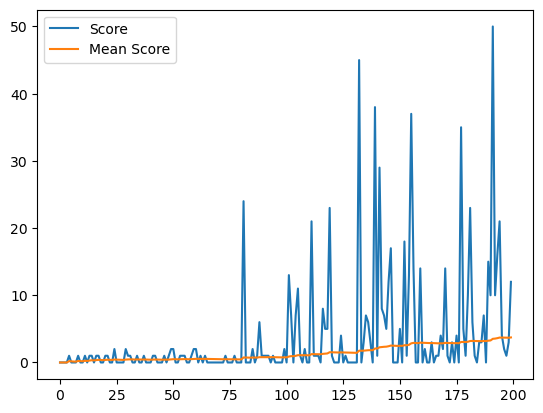

In [9]:
import matplotlib.pyplot as plt

plt.plot(scoresHistory)
plt.plot(meanScores)
plt.legend(["Score", "Mean Score"])

# Conclusion

I think the outcome is pretty amazing, using RL we manage to obtain a decent performing AI in a very short amount of time. Looking at the first iterations of the training the AI is clueless (as it's expected), GIF bellow.

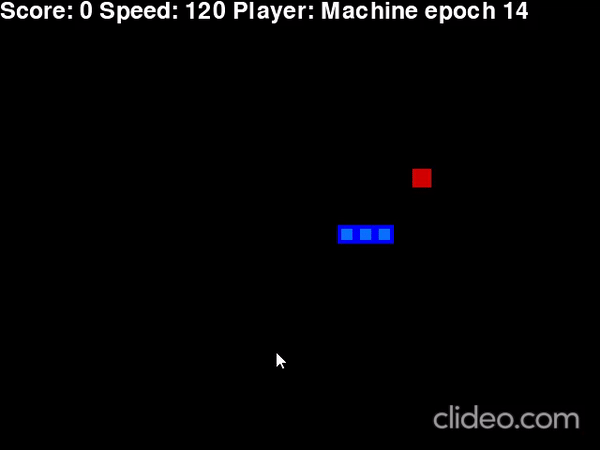

But it get very fast to be pretty good.

I quite like the performance above, it looks pretty competent.

Event after we have some succes with our model it can be put in dificult conditions, doing silly things like the video bellow.

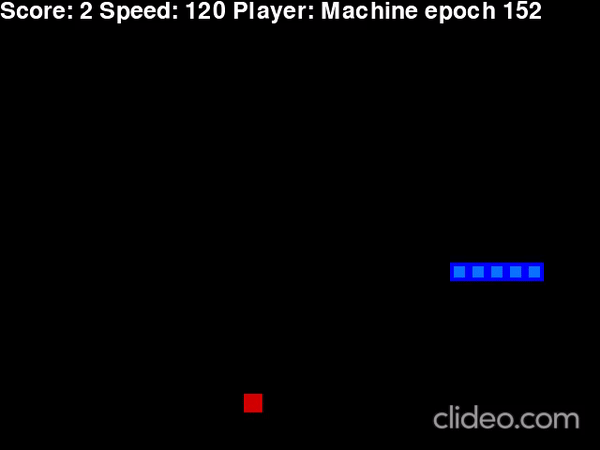

I suspect this types of "halucinations" will be less frequent once we increase the training.

# Finish

You have made it to the finish, thank you! Please upvote if you liked this notebook :)